# Generating figures for entropy by phylogeny / taxonomy

In [1]:
library(ggplot2)
library(plyr)

In [2]:
WindowAvg <- ggproto("WindowAvg", Stat, 
    required_aes = c("x", "y"),
  
    compute_group = function(., data, scales, FUN, xwindow, xstep, ...) {
        xmin <- min(data$x)
        xmax <- max(data$x)
        
        if(is.na(xwindow)) {
            xwindow = (xmax - xmin) / 100
        }

        if(is.na(xstep)) {
            xstep = (xmax - xmin) / 1000
        }

        spots <- seq(from=xmin, to=xmax-xwindow, by=xstep)

        yspots <- vector(length = length(spots))

        for(i in 1:length(spots)) {
            yspots[i] <- FUN(subset(data, spots[i] <= x & x < spots[i] + xwindow)$y)
            }

        result <- na.omit(data.frame(x=(spots + xwindow/2), y =yspots))

        result
    }
)

window_avg <- function(mapping = NULL, data = NULL, geom = "line",
                    position = "identity", na.rm = FALSE, show.legend = NA, 
                    inherit.aes = TRUE, xwindow=NA, xstep=NA, FUN=mean, ...) {
  layer(
    stat = WindowAvg, data = data, mapping = mapping, geom = geom, 
    position = position, show.legend = show.legend, inherit.aes = inherit.aes,
    params = list(xwindow=xwindow, xstep=xstep, FUN=FUN, ...)
  )
}

In [3]:
e <- read.csv('./entropy-tree.txt', sep = '\t')
e_r <- read.csv('./entropy-tree-random.txt', sep = '\t')

e$perm = 'Real'
e_r$perm = 'Permuted'

b = rbind(e, e_r)

In [4]:
## Calculating values, thresholding by min samples

b_s10 <- subset(b, num_samp >= 10)
b_s10$sample_threshold = 's010'
b_s20 <- subset(b, num_samp >= 20)
b_s20$sample_threshold = 's020'
b_s50 <- subset(b, num_samp >= 50)
b_s50$sample_threshold = 's050'
b_s100 <- subset(b, num_samp >= 100)
b_s100$sample_threshold = 's100'
b_s200 <- subset(b, num_samp >= 200)
b_s200$sample_threshold = 's200'
b_s1 <- subset(b, num_samp >= 1)
b_s1$sample_threshold = 's001'

b_s <- rbind(b_s1, b_s10, b_s20, b_s50, b_s100, b_s200)


## Calculating values, thresholding by min number of tips

b_c1 <- subset(b, num_children >= 1)
b_c1$children_threshold = 'c001'
b_c5 <- subset(b, num_children >= 5)
b_c5$children_threshold = 'c005'
b_c10 <- subset(b, num_children >= 10)
b_c10$children_threshold = 'c010'
b_c20 <- subset(b, num_children >= 20)
b_c20$children_threshold = 'c020'
b_c50 <- subset(b, num_children >= 50)
b_c50$children_threshold = 'c050'
b_c100 <- subset(b, num_children >= 100)
b_c100$children_threshold = 'c100'

b_c <- rbind(b_c1, b_c5, b_c10, b_c20, b_c50, b_c100)

In [5]:
## Plotting figure parameters

colors = c("Real" = "#8da0cb", "Permuted" = "#66c2a5")
alpha = 0.7

In [6]:
## Calculating mean and quintiles for real, single sub_OTUs

sotu_df = subset(b_s10, num_children == 0 & perm == 'Real')
sotu_df$level = 8
sotu_df$level_name = 'Unique tag sequences'

sotu_numbers = data.frame(xmean=0,
                          ymean=mean(sotu_df$entropy),
                          q20 = quantile(sotu_df$entropy,0.2),
                          q80 = quantile(sotu_df$entropy,0.8),
                          perm = 'Real')

In [7]:
# Find 97% nucleotide divergence for plotting line
tipdists = read.table('./tree_distances.txt', sep = '\t', col.names=c('Patristic_distance','ANI'))

ani_lm <- lm(data = subset(tipdists, ANI > 0.8), Patristic_distance ~ ANI)
exp_97 = .97 * ani_lm$coefficients['ANI'] + ani_lm$coefficients['(Intercept)']

plot_tipdists <- ggplot(subset(tipdists, ANI > 0.8), aes(x = ANI, y = Patristic_distance)) +
                    geom_point(alpha = 0.07) + geom_smooth(method = lm) +
                    ggtitle('Patristic distances vs average nucleotide identity') +
                    theme_bw()

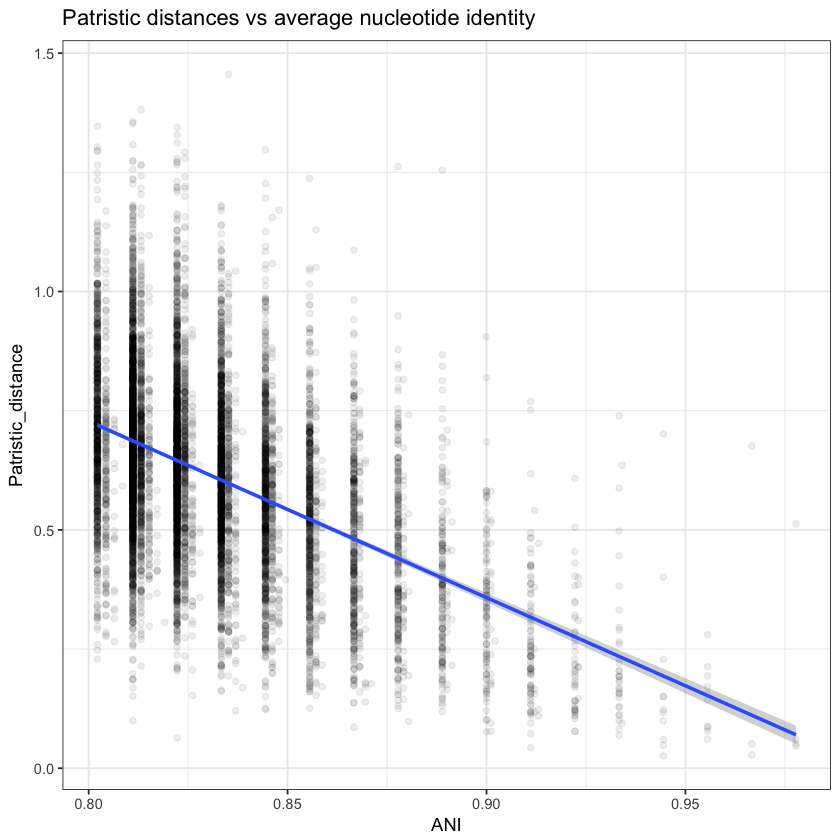

In [8]:
plot_tipdists

In [ ]:
#ggsave('./patristic_distance-by-ANI.pdf', plot = plot_tipdists, width = 4, height = 3)

In [9]:
# find average patristic distances for taxonomy levels

taxlevels = read.table('./taxonomy_width.txt', sep = '\t', header = TRUE)

taxlevel_sum <- ddply(na.omit(taxlevels), c("level"), summarise,
               N    = length(max_width),
               mean = mean(max_width),
               sd   = sd(max_width),
               se   = sd / sqrt(N),
               q20  = quantile(max_width,0.2),
               q80 = quantile(max_width,0.8))

taxlevel_sum[7,] <- c(8,NA,exp_97,NA,NA,NA,NA)

taxlevel_sum$y = (9 - as.numeric(taxlevel_sum$level)) / 2

taxlevel_sum$level_name <- c('Phylum','Class','Order','Family','Genus','Species','97%')
taxlevel_sum$perm <- NA

In [10]:
#### Plotting sliding window plots

## values for sliding window calc

xwindow = max(b_s$max.tip.tip.dist) / 50
xstep = max(b_s$max.tip.tip.dist) / 200


## Plotting thresholds by tips, colored by level and faceted by permuted

tree_entropy_tips_facets <- ggplot(b_c, aes(x = max.tip.tip.dist, y = entropy, color=children_threshold)) +
    theme_bw() + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=mean) + 
    geom_vline(xintercept = exp_97, linetype=2, color = 'black') + 
    geom_pointrange(data=sotu_numbers,
                    mapping=aes(x=xmean, y=ymean, ymin=q20, ymax=q80),
                    fill="white", shape=22, color = 'black') +
    facet_wrap(~ perm) + 
    ggtitle("Entropy by maximum branch length per node,\nthresholded by number of tips per node") +
    ylab('Entropy') + 
    xlab('Maximum tip-to-tip branch length') + 
    scale_color_discrete(name="Tip number\nthreshold:")

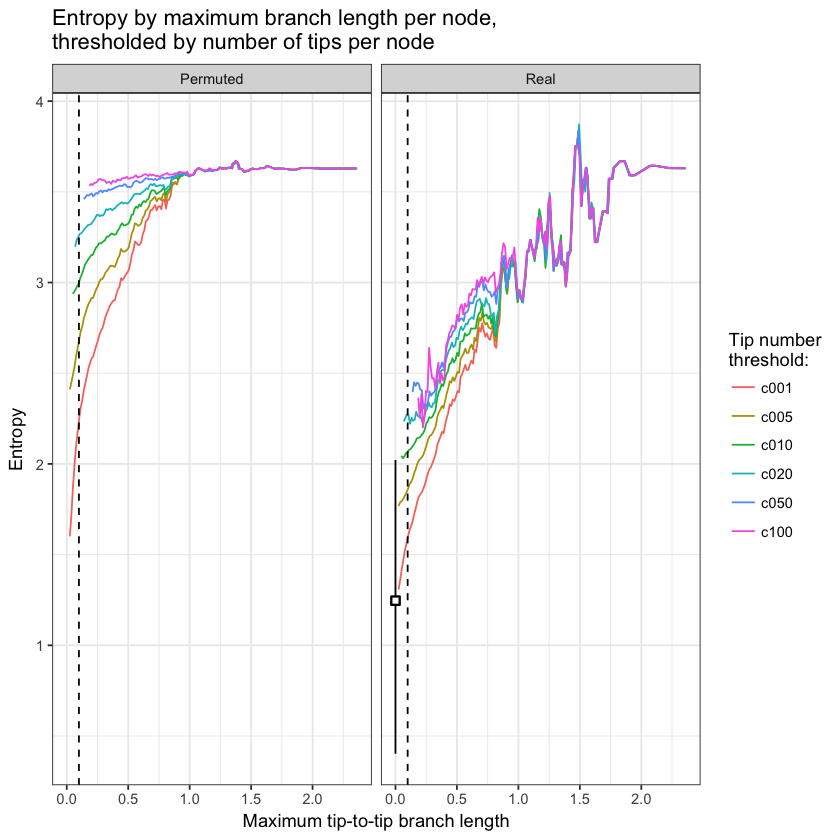

In [11]:
tree_entropy_tips_facets

In [ ]:
ggsave(plot = tree_entropy_tips_facets,
       file ='./tree-entropy_window_avg_tip-threshold_faceted.pdf', 
       width = 8,
       height = 5)

In [12]:
## Plotting thresholds by sample, colored by level and faceted by permuted

tree_entropy_samples_facets <- ggplot(b_s, aes(x = max.tip.tip.dist, y = entropy, color=sample_threshold)) +
    theme_bw() + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=mean) + 
    geom_vline(xintercept = exp_97, linetype=2, color = 'black') + 
    geom_pointrange(data=sotu_numbers,
                    mapping=aes(x=xmean, y=ymean, ymin=q20, ymax=q80),
                    fill="white", shape=22, color = 'black') +
    facet_wrap(~ perm) + 
    ggtitle("Entropy by maximum branch length per node,\nthresholded by number of samples per tag sequence") +
    ylab('Entropy') + 
    xlab('Maximum tip-to-tip branch length') + 
    scale_color_discrete(name="Sample number\nthreshold:")

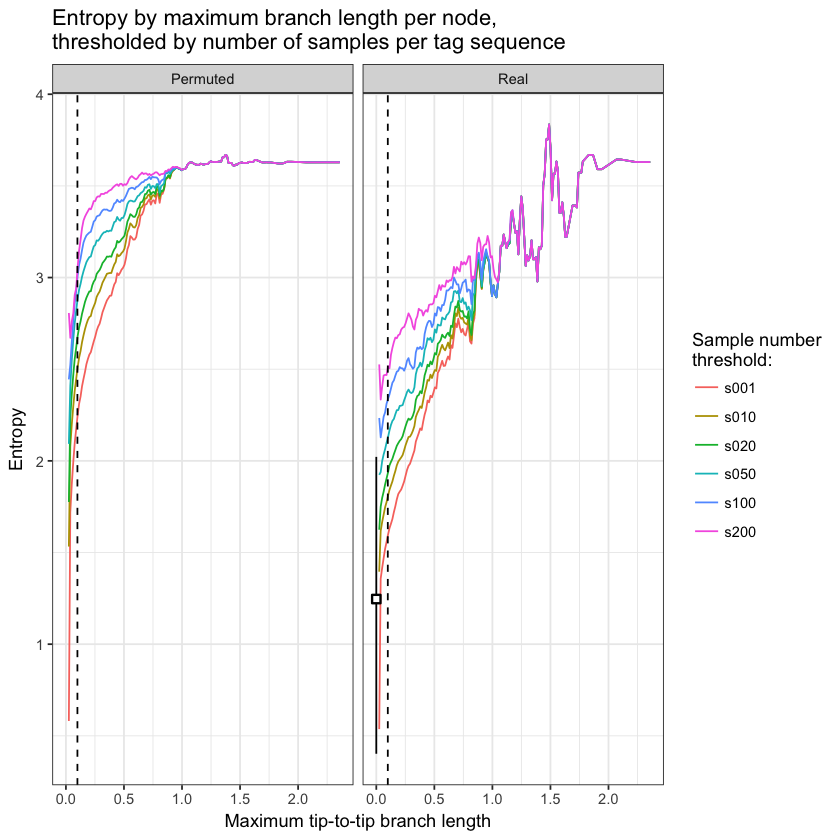

In [13]:
tree_entropy_samples_facets

In [ ]:
ggsave(plot = tree_entropy_samples_facets,
       file ='./tree-entropy_window_avg_sample-threshold_faceted.pdf', 
       width = 8,
       height = 5)

In [14]:
## Plotting entropy for tips >= 20, colored by permutation

text_alpha = .5
quintile_alpha = .5
violin_alpha = 0.3
box_alpha = 0.2
vline_alpha = .8

In [15]:
tree_entropy_c20 <- ggplot(subset(b_c, children_threshold == 'c020'), aes(x = max.tip.tip.dist, y = entropy, color=perm, fill = perm)) +
    theme_bw() + 
    geom_violin(data = sotu_df, alpha = violin_alpha, size = 0) +
    window_avg(xwindo =xwindow, xstep=xstep, FUN=mean) + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=function(x)quantile(x,0.8), alpha = quintile_alpha) + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=function(x)quantile(x,0.2), alpha = quintile_alpha) +
    geom_vline(data = taxlevel_sum, aes(xintercept=mean), linetype = 3, alpha = vline_alpha, color = 'black') +
    geom_text(data = taxlevel_sum, aes(x=mean, y=y, label=level_name),
              alpha = text_alpha, color = 'black', angle = 90, hjust=1, vjust = 1.1) +
    geom_pointrange(data=sotu_numbers,
                 mapping=aes(x=xmean, y=ymean, ymin=q20, ymax=q80),
                 fill="white", shape=22)+ 
    annotate("text", x = sotu_numbers$xmean[1], y = sotu_numbers$ymean[1],
             label = "Unique tag sequences", color = 'black', alpha = text_alpha, angle = 90, vjust = -0.9) +
    ylab('Entropy') + 
    xlab('Maximum tip-to-tip branch length') + 
    scale_colour_manual(name="Permutation:", values = colors) +
    scale_fill_manual(values = colors, guide=FALSE) +
    theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank()) +
    theme(legend.justification=c(1,0), legend.position=c(1,0), 
          legend.title=element_blank(), legend.background = element_rect(fill=alpha('white', 0.4)))

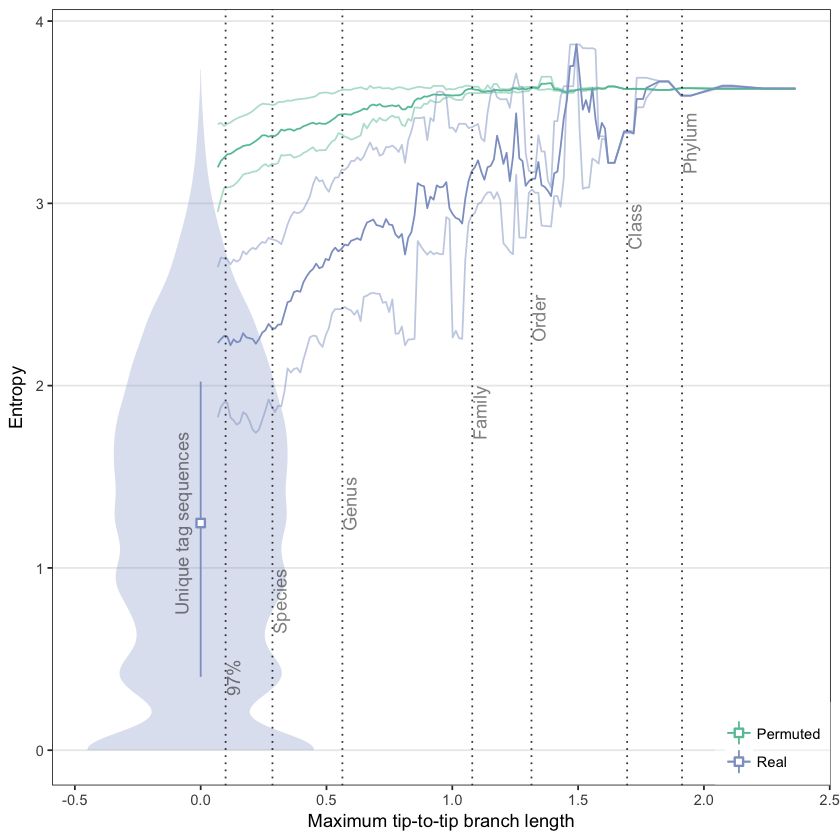

In [16]:
tree_entropy_c20

In [37]:
# save data output for entropy per clade as a function of clade width, minimum of 20 tips per clade

write.csv(subset(b_c, children_threshold == 'c020')[,c('max.tip.tip.dist','entropy','perm')],
          file = '../../../../data/07-entropy-and-covariation/entropy_by_phylogeny_c20.csv',
          quote = FALSE)

In [38]:
# save data output for entropy per tag sequence (violin plot), minimum of 10 samples per sequence

write.csv(sotu_df[,c('num_samp','entropy')],
          file = '../../../../data/07-entropy-and-covariation/entropy_per_tag_sequence_s10.csv',
          quote = FALSE)

In [ ]:
ggsave(plot = tree_entropy_c20,
       file ='./tree-entropy_window_avg_tips20.pdf', 
       width = 5,
       height = 4)

In [17]:
## Plotting entropy for tips >= 50, colored by permutation

tree_entropy_c50 <- ggplot(subset(b_c, children_threshold == 'c050'), aes(x = max.tip.tip.dist, y = entropy, color=perm, fill = perm)) +
    theme_bw() + 
    geom_violin(data = sotu_df, alpha = violin_alpha, size = 0) +
    window_avg(xwindo =xwindow, xstep=xstep, FUN=mean) + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=function(x)quantile(x,0.8), alpha = quintile_alpha) + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=function(x)quantile(x,0.2), alpha = quintile_alpha) +
    geom_vline(data = taxlevel_sum, aes(xintercept=mean), linetype = 3, alpha = vline_alpha, color = 'black') +
    geom_text(data = taxlevel_sum, aes(x=mean, y=y, label=level_name),
              alpha =  text_alpha, color = 'black', angle = 90, hjust=1, vjust = 1.1) +
    geom_pointrange(data=sotu_numbers,
                 mapping=aes(x=xmean, y=ymean, ymin=q20, ymax=q80),
                 fill="white", shape=22) + 
    annotate("text", x = sotu_numbers$xmean[1], y = sotu_numbers$ymean[1],
             label = "Unique tag sequences", color = 'black', alpha = text_alpha, angle = 90, vjust = -0.9) +
    ylab('Entropy') + 
    xlab('Maximum tip-to-tip branch length') + 
    scale_colour_manual(name="Permutation:", values = colors) +
    scale_fill_manual(values = colors, guide=FALSE) +
    theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank()) +
    theme(legend.justification=c(1,0), legend.position=c(1,0), 
          legend.title=element_blank(), legend.background = element_rect(fill=alpha('white', 0.4)))

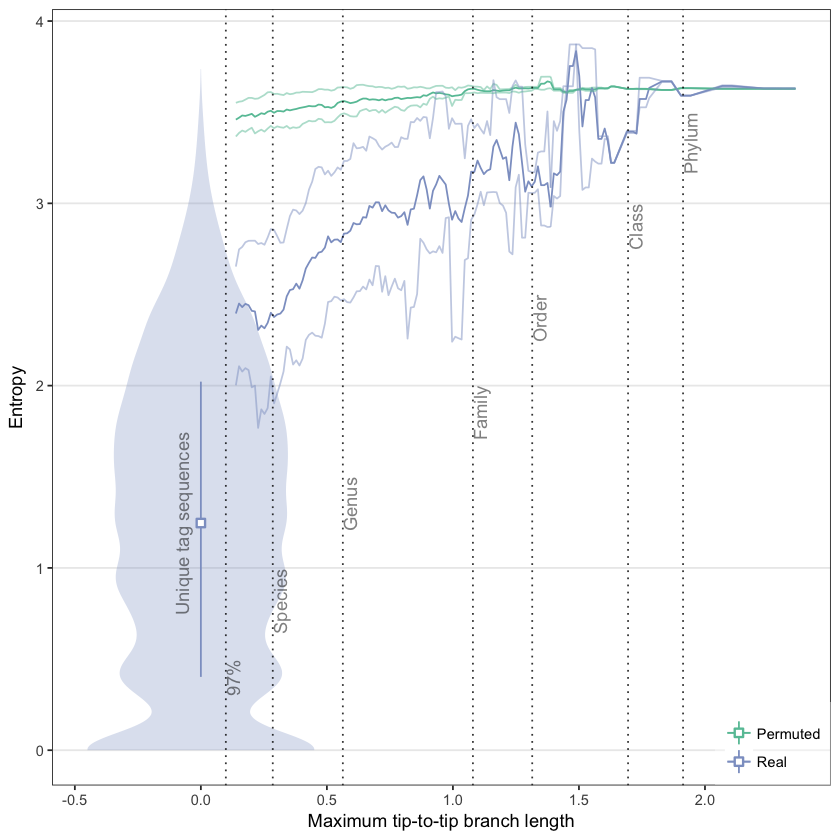

In [18]:
tree_entropy_c50

In [ ]:
ggsave(plot = tree_entropy_c50,
       file ='./tree-entropy_window_avg_tips50.pdf', 
       width = 5,
       height = 4)

In [19]:
## Plotting entropy for samples >= 10, colored by permutation

tree_entropy_s10 <- ggplot(subset(b_s, sample_threshold == 's010'), aes(x = max.tip.tip.dist, y = entropy, color=perm, fill = perm)) +
    theme_bw() + 
    geom_violin(data = sotu_df, alpha = violin_alpha, size = 0) +
    window_avg(xwindo =xwindow, xstep=xstep, FUN=mean) + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=function(x)quantile(x,0.8), alpha = quintile_alpha) + 
    window_avg(xwindo =xwindow, xstep=xstep, FUN=function(x)quantile(x,0.2), alpha = quintile_alpha) +
    geom_vline(data = taxlevel_sum, aes(xintercept=mean), linetype = 3, alpha = vline_alpha, color = 'black') +
    geom_text(data = taxlevel_sum, aes(x=mean, y=y, label=level_name),
              alpha =  text_alpha, color = 'black', angle = 90, hjust=1, vjust = 1.1) +
    geom_pointrange(data=sotu_numbers,
                 mapping=aes(x=xmean, y=ymean, ymin=q20, ymax=q80),
                 fill="white", shape=22) + 
    annotate("text", x = sotu_numbers$xmean[1], y = sotu_numbers$ymean[1],
             label = "Unique tag sequences", color = 'black', alpha = text_alpha, angle = 90, vjust = -0.9) +
    ylab('Entropy') + 
    xlab('Maximum tip-to-tip branch length') + 
    scale_colour_manual(name="Permutation:", values = colors) +
    scale_fill_manual(values = colors, guide=FALSE) +
    theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank()) +
    theme(legend.justification=c(1,0), legend.position=c(1,0), 
          legend.title=element_blank(), legend.background = element_rect(fill=alpha('white', 0.4)))

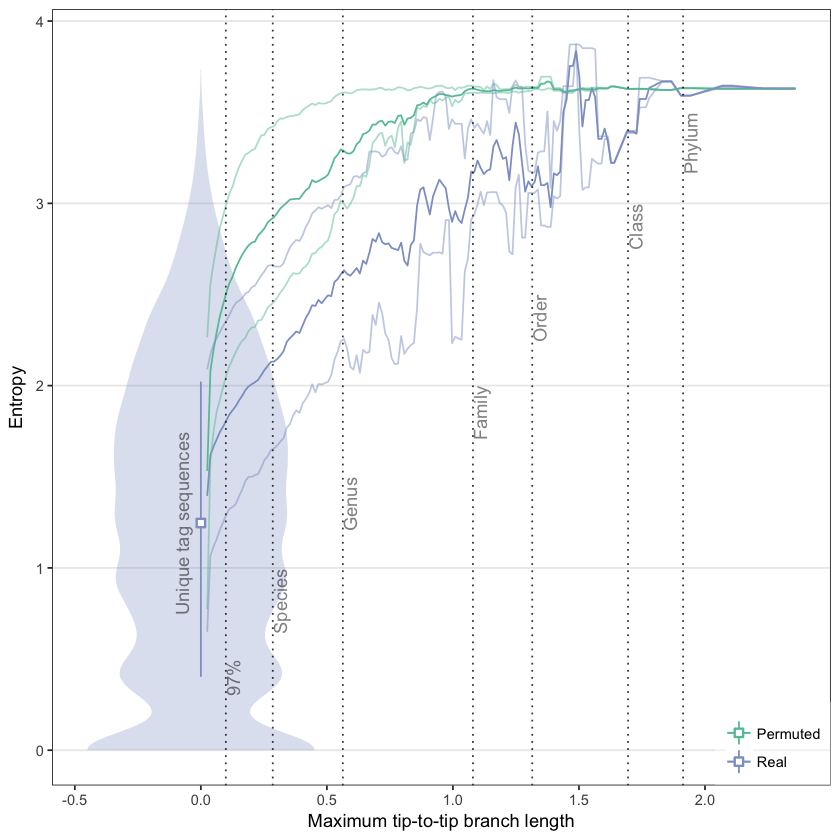

In [20]:
tree_entropy_s10

In [ ]:
ggsave(plot = tree_entropy_s10,
       file ='./tree-entropy_window_avg_samples10.pdf', 
       width = 5,
       height = 4)

In [21]:
#### Plotting taxonomy level entropy plots

e_t <- read.csv('./entropy_taxalevel.txt', sep = '\t')
e_tr <- read.csv('./entropy_taxalevel_permuted.txt', sep = '\t')

e_t$perm = 'Real'
e_tr$perm = 'Permuted'

e_tax = rbind(e_t, e_tr)

e_tax$level <- as.character(e_tax$level)

e_tax$level_name[e_tax$level == 1] <- 'Kingdom'
e_tax$level_name[e_tax$level == 2] <- 'Phylum'
e_tax$level_name[e_tax$level == 3] <- 'Class'
e_tax$level_name[e_tax$level == 4] <- 'Order'
e_tax$level_name[e_tax$level == 5] <- 'Family'
e_tax$level_name[e_tax$level == 6] <- 'Genus'
e_tax$level_name[e_tax$level == 7] <- 'Species'

e_tax$level_name <- factor(e_tax$level_name, level = c('Species','Genus','Family','Order','Class','Phylum','Kingdom'))

taxaplot_labels = data.frame(x = c('1','2,','3','4','5','6','7','8'),
                             y = c(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1),
                             level_order = c(7,6,5,4,3,2,1,0),
                             level_name = c('Kingdom','Phylum','Class','Order','Family','Genus','Species', 'Unique tag sequences'))

In [22]:
# Filter taxonomy table to taxa with >= a certain number of unique seq tags

filt_num = 20

e_tax_filt <- subset(e_tax, num_children >= filt_num)
a <- rbind(e_tax_filt, sotu_df[, colnames(e_tax)])
a$level_name <- factor(a$level_name, level = c('Unique tag sequences','Species','Genus','Family','Order','Class','Phylum','Kingdom'))
a$level_order = 8 - as.numeric(a$level)

In [23]:
# Add N info to taxaplot_labels

fn <- function(x) sum(a$level_name == x)
taxaplot_labels$n <- sapply(taxaplot_labels$level_name, fn)
taxaplot_labels$level_n <- paste(taxaplot_labels$level_name, ' (n=', taxaplot_labels$n, ')', sep='')

In [24]:
# Plot taxonomy box plot

taxa_entropy_c20 <- ggplot() +
    geom_boxplot(data = subset(a, level < 8 & level > 1), aes(factor(level_order), entropy, fill=perm, color=perm), alpha = box_alpha) +
    geom_violin(data = subset(a, level == 8), aes(factor(level_order), entropy, fill=perm, color=perm), alpha = violin_alpha, size = 0) +
    theme_bw() + 
    ylab('Entropy') + 
    xlab('Taxonomy level') + 
    scale_colour_manual(name="Permutation:", values = colors) +
    scale_fill_manual(values = colors, guide=FALSE) +
    scale_y_continuous(limits = c(0,4)) +
    geom_text(data = subset(taxaplot_labels, level_order < 7), aes(x = factor(level_order), y = y, label = level_n),
              alpha = text_alpha, color = 'black', angle = 90, hjust=0, vjust = 0.2) + 
    theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(),
          panel.grid.minor.y = element_blank(),
          axis.text.x = element_blank(), legend.position = "none")

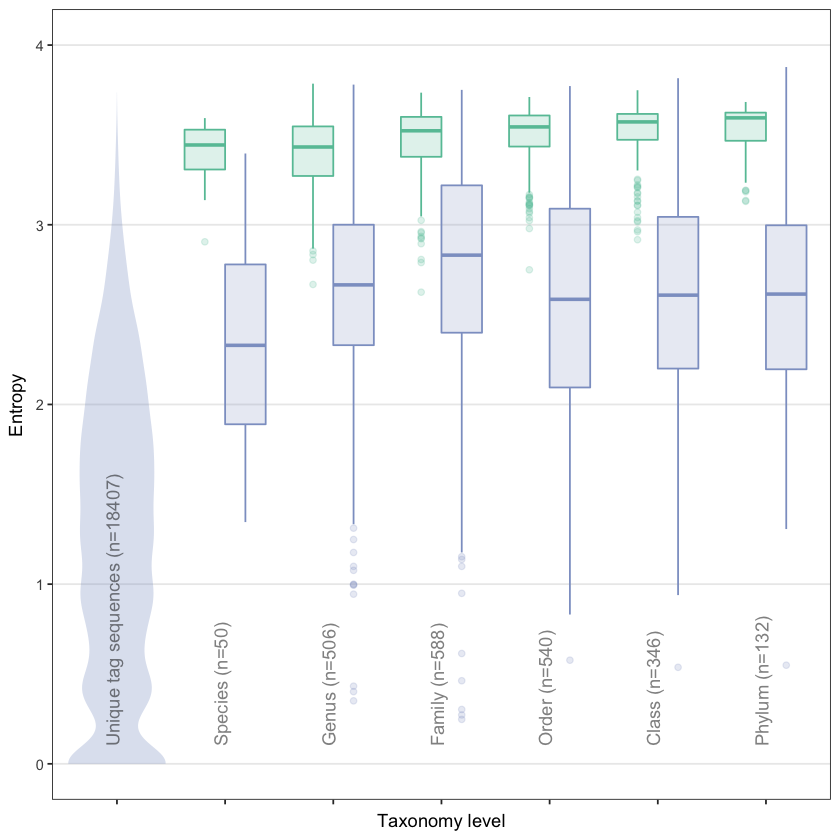

In [25]:
taxa_entropy_c20

In [41]:
# save data output for entropy per clade as a function of clade width, minimum of 20 tips per clade

write.csv(subset(a, level < 8 & level > 1)[,c('perm','level_name','entropy')],
          file = '../../../../data/07-entropy-and-covariation/entropy_by_taxonomy_c20.csv',
          quote = FALSE)

In [ ]:
ggsave(plot = taxa_entropy_c20,
       file ='./taxa-entropy_window_avg_tips20.pdf', 
       width = 5,
       height = 4)